In [ ]:
# Import merged df
import pandas as pd
merged = pd.read_csv('../data/test/merged_small.csv')

display(merged.head())
print("Unique Video IDs:", merged["video_id"].nunique())
print("Unique User IDs:", merged["user_id"].nunique())


/var/folders/18/k3vb5tx15r921kvp0jfm94sr0000gn/T/ipykernel_20220/1337462579.py:3: DtypeWarning: Columns (15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  merged = pd.read_csv('../data/test/merged_small.csv')


,user_id,video_id,play_duration_x,video_duration_x,time,date_x,timestamp,watch_ratio,user_active_degree,is_lowactive_period,...,download_user_num,report_cnt,report_user_num,reduce_similar_cnt,reduce_similar_user_num,collect_cnt,collect_user_num,cancel_collect_cnt,cancel_collect_user_num,num_friends
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103,full_active,0,...,4.523810,0.000000,0.000000,35.936508,34.777778,0.175,0.175,0.050,0.050,NaN
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377,full_active,0,...,10.444444,0.047619,0.047619,51.809524,50.619048,0.250,0.250,0.200,0.200,NaN
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311,full_active,0,...,48.079365,0.095238,0.095238,52.666667,51.634921,0.175,0.175,0.325,0.325,NaN
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388,full_active,0,...,122.253968,0.238095,0.222222,399.730159,384.047619,14.400,14.325,5.350,5.350,NaN
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364,full_active,0,...,2.793651,0.015873,0.015873,23.365079,22.825397,0.075,0.075,0.000,0.000,NaN


Unique Video IDs: 3327
Unique User IDs: 31
Index(['user_id', 'video_id', 'play_duration_x', 'video_duration_x', 'time',
       'date_x', 'timestamp', 'watch_ratio', 'user_active_degree',
       'is_lowactive_period', 'is_live_streamer', 'is_video_author',
       'follow_user_num_x', 'follow_user_num_range', 'fans_user_num',
       'fans_user_num_range', 'friend_user_num', 'friend_user_num_range',
       'register_days', 'register_days_range', 'feat', 'category_features',
       'date_y', 'author_id', 'video_duration_y', 'video_width',
       'video_height', 'music_id', 'video_tag_id', 'show_cnt', 'show_user_num',
       'play_cnt', 'play_user_num', 'play_duration_y', 'complete_play_cnt',
       'complete_play_user_num', 'valid_play_cnt', 'valid_play_user_num',
       'long_time_play_cnt', 'long_time_play_user_num', 'short_time_play_cnt',
       'short_time_play_user_num', 'play_progress', 'comment_stay_duration',
       'like_cnt', 'like_user_num', 'click_like_cnt', 'double_click_cnt',

In [2]:
# Let's build a user-item matrix
user_item_matrix = merged.pivot_table(
    index="user_id", columns="video_id", values="watch_ratio", fill_value=0
)
display(user_item_matrix.head())


video_id,103,109,120,122,128,130,131,133,136,137,...,10430,10436,10457,10462,10500,10506,10519,10552,10589,10595
user_id,,,,,,,,,,,,,,,,,,,,,
14,0.429126,1.482039,0.728738,0.477810,0.439333,1.150245,1.816317,0.781122,1.554396,2.307486,...,0.348932,0.965220,1.787169,1.816010,0.150323,1.535256,2.757278,0.143556,1.273362,1.719201
19,0.624466,1.070684,1.006064,0.759092,0.882691,0.639313,0.670019,1.407319,0.874814,0.722665,...,0.642896,0.633833,0.586222,1.178295,0.000000,0.977297,1.266322,0.265038,0.928168,1.107873
21,1.415049,1.028840,1.809125,0.688823,0.588365,0.619549,0.818749,1.944596,1.015039,0.575723,...,0.896847,0.918930,0.602573,0.995887,1.173871,0.957399,1.148837,0.216699,1.210398,1.713792
23,0.169223,2.549891,0.247487,0.438669,0.114338,0.828292,0.038440,2.455882,1.128438,1.021400,...,0.577134,0.335534,5.304503,0.610346,0.185161,4.725427,0.338674,0.430445,2.225363,0.000000
24,0.345049,0.449337,0.802936,0.797411,1.875599,0.783867,2.104939,6.418434,0.228018,3.892566,...,0.884743,0.578658,0.300125,2.151558,2.311935,1.848424,0.388630,0.103633,0.547944,0.093900


In [6]:
# User-level aggregates
user_agg = merged.groupby("user_id").agg(
    {
        "watch_ratio": ["mean", "std"],
        "like_cnt": "mean",
        "comment_cnt": "mean",
        "share_cnt": "mean",
    }
)
user_agg.columns = [
    "user_watch_ratio_mean",
    "user_watch_ratio_std",
    "user_like_mean",
    "user_comment_mean",
    "user_share_mean",
]
user_agg = user_agg.reset_index()

# Item-level aggregates
item_agg = merged.groupby("video_id").agg(
    {
        "watch_ratio": ["mean", "std", "count"],
        "like_cnt": "mean",
        "comment_cnt": "mean",
        "share_cnt": "mean",
    }
)
item_agg.columns = [
    "item_watch_ratio_mean",
    "item_watch_ratio_std",
    "item_like_mean",
    "item_comment_mean",
    "item_share_mean",
    "item_watch_ratio_count",
]
item_agg = item_agg.reset_index()

display(user_agg.head())
display(item_agg.head())

,user_id,user_watch_ratio_mean,user_watch_ratio_std,user_like_mean,user_comment_mean,user_share_mean
0,14,0.997809,1.065740,8777.771967,462.867516,313.745142
1,19,0.836359,0.416786,8749.320732,462.376657,315.346586
2,21,0.947653,0.947987,8807.145463,459.862650,316.165653
3,23,1.024486,1.492576,8587.254487,443.989067,311.376265
4,24,0.864112,1.628206,8752.385304,457.391942,315.575171


,video_id,item_watch_ratio_mean,item_watch_ratio_std,item_like_mean,item_comment_mean,item_share_mean,item_watch_ratio_count
0,103,0.828615,0.542348,30,1549.269841,8.396825,99.952381
1,109,1.037994,0.573307,31,629.047619,11.904762,2.253968
2,120,1.103180,0.500161,31,2683.634921,61.000000,39.476190
3,122,0.723046,0.383198,31,169.301587,7.460317,3.873016
4,128,0.704681,0.359460,31,10863.793651,132.793651,62.587302


In [8]:
item_agg["popularity"] = item_agg["item_watch_ratio_count"]
item_agg["popularity_score"] = (
    item_agg["popularity"] - item_agg["popularity"].min()
) / (item_agg["popularity"].max() - item_agg["popularity"].min() + 1e-10)

print("Adding popularity score")
display(item_agg)

Adding popularity score


,video_id,item_watch_ratio_mean,item_watch_ratio_std,item_like_mean,item_comment_mean,item_share_mean,item_watch_ratio_count,popularity,popularity_score
0,103,0.828615,0.542348,30,1549.269841,8.396825,99.952381,99.952381,0.002116
1,109,1.037994,0.573307,31,629.047619,11.904762,2.253968,2.253968,0.000048
2,120,1.103180,0.500161,31,2683.634921,61.000000,39.476190,39.476190,0.000836
3,122,0.723046,0.383198,31,169.301587,7.460317,3.873016,3.873016,0.000082
4,128,0.704681,0.359460,31,10863.793651,132.793651,62.587302,62.587302,0.001325
...,...,...,...,...,...,...,...,...,...
3322,10506,1.215056,0.782297,29,4034.555556,482.888889,36.333333,36.333333,0.000769
3323,10519,1.657674,1.317636,30,8099.000000,1805.375000,33.875000,33.875000,0.000717
3324,10552,0.330114,0.300510,30,513749.714286,16206.714286,6652.285714,6652.285714,0.140816
3325,10589,0.882349,0.485715,30,229917.600000,27773.600000,1397.200000,1397.200000,0.029576


In [10]:
# LET'S CREATE A ENGAGEMENT SCORE

# Formula between watch ratio, like ratio, comment ratio, and share ratio
w1, w2, w3, w4, w5 = 0.30, 0.10, 0.25, 0.15, 0.20  # Weights
item_agg["engagement_score"] = (
    w1 * item_agg["item_watch_ratio_mean"]
    + w2
    * (
        item_agg["item_watch_ratio_std"] + 0.01
    )  # Add small constant to avoid zero values
    + w3 * item_agg["item_like_mean"]
    + w4 * item_agg["item_comment_mean"]
    + w5 * item_agg["item_share_mean"]
)

# Sort by engagement score
item_agg = item_agg.sort_values("engagement_score", ascending=False)
display(item_agg.head())

,video_id,item_watch_ratio_mean,item_watch_ratio_std,item_like_mean,item_comment_mean,item_share_mean,item_watch_ratio_count,popularity,popularity_score,engagement_score
3324,10552,0.330114,0.300510,30,513749.714286,16206.714286,6652.285714,6652.285714,0.140816,80311.430085
2601,7814,0.098671,0.159311,30,264769.900000,8197.800000,1113.300000,1113.300000,0.023566,41362.591532
3325,10589,0.882349,0.485715,30,229917.600000,27773.600000,1397.200000,1397.200000,0.029576,40050.174276
1718,5027,1.197339,0.817618,30,221842.250000,7961.500000,919.750000,919.750000,0.019469,34876.579463
3317,10430,1.029696,2.211818,30,216483.916667,10757.333333,9463.250000,9463.250000,0.200318,34632.085257


In [13]:
# Normalize engagement score
item_agg["engagement_score"] = (
    item_agg["engagement_score"] - item_agg["engagement_score"].min()
) / (
    item_agg["engagement_score"].max() - item_agg["engagement_score"].min() + 1e-10
)

# Create a hybrid score (engagement + popularity)
item_agg["hybrid_score"] = (
    0.7 * item_agg["engagement_score"] + 0.3 * item_agg["popularity_score"]
)

display(item_agg)

# Save the item_agg dataframe to a CSV file
item_agg.to_csv("../data/test/item_agg.csv", index=False)

,video_id,item_watch_ratio_mean,item_watch_ratio_std,item_like_mean,item_comment_mean,item_share_mean,item_watch_ratio_count,popularity,popularity_score,engagement_score,hybrid_score
3324,10552,0.330114,0.300510,30,513749.714286,16206.714286,6652.285714,6652.285714,1.408155e-01,1.000000e+00,0.742245
2601,7814,0.098671,0.159311,30,264769.900000,8197.800000,1113.300000,1113.300000,2.356632e-02,5.149647e-01,0.367545
3325,10589,0.882349,0.485715,30,229917.600000,27773.600000,1397.200000,1397.200000,2.957591e-02,4.986210e-01,0.357907
1718,5027,1.197339,0.817618,30,221842.250000,7961.500000,919.750000,919.750000,1.946926e-02,4.341935e-01,0.309776
3317,10430,1.029696,2.211818,30,216483.916667,10757.333333,9463.250000,9463.250000,2.003180e-01,4.311488e-01,0.361900
...,...,...,...,...,...,...,...,...,...,...,...
149,533,1.121485,0.435838,30,20.722222,0.166667,0.037037,0.037037,7.839996e-07,7.850748e-06,0.000006
1410,4057,0.116369,0.056123,30,22.311111,0.111111,0.200000,0.200000,4.233598e-06,6.452460e-06,0.000006
1466,4141,0.069626,0.096454,29,23.853659,0.121951,0.024390,0.024390,5.162924e-07,6.123203e-06,0.000004
867,2422,0.253265,0.126282,30,18.913043,0.195652,0.130435,0.130435,2.761042e-06,9.143340e-07,0.000001


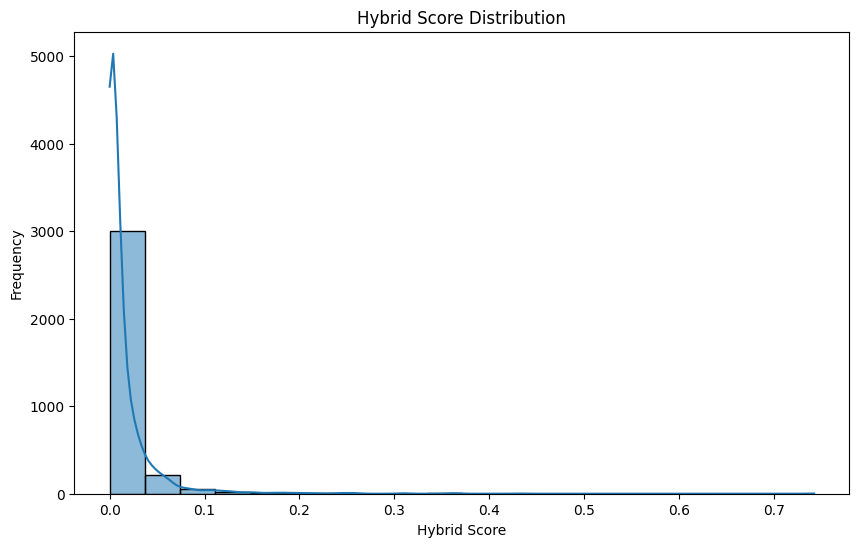

In [14]:
# Let's plot the hybrid score distribution
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(item_agg["hybrid_score"], bins=20, kde=True)
plt.title("Hybrid Score Distribution")
plt.xlabel("Hybrid Score")
plt.ylabel("Frequency")
plt.show()

In [17]:
# Evaluate the hybrid score
from sklearn.model_selection import train_test_split

train, test = train_test_split(merged, test_size=0.2, random_state=42)


def hit_rate_at_k(test_df, top_k_items):
    hits = 0
    total_users = test_df["user_id"].nunique()
    for user in test_df["user_id"].unique():
        user_items = test_df[test_df["user_id"] == user]["video_id"].values
        if any(item in top_k_items for item in user_items):
            hits += 1
    return hits / total_users


top_k_items = (
    item_agg.sort_values("hybrid_score", ascending=False).head(10)["video_id"].tolist()
)
hit_rate = hit_rate_at_k(test, top_k_items)
print(f"Hit Rate @10: {hit_rate:.4f}")

Hit Rate @10: 0.8065


In [18]:
def precision_at_k(test_df, item_scores, k=10):
    user_precision = []
    for user_id in test_df["user_id"].unique():
        actual_items = test_df[test_df["user_id"] == user_id]["video_id"].tolist()
        recommended_items = item_scores.sort_values("hybrid_score", ascending=False)[
            "video_id"
        ].tolist()[:k]
        hits = len(set(recommended_items) & set(actual_items))
        user_precision.append(hits / k)
    return sum(user_precision) / len(user_precision)


precision = precision_at_k(test, item_agg, k=10)
print(f"Precision @10: {precision:.4f}")

Precision @10: 0.2000
